<h1>Using a neural network to approximate a 1-D function</h1>

In [46]:
from IPython import get_ipython  
get_ipython().magic('reset -sf')

In [47]:
import numpy as np
from math import sin, cos, pi, exp, log
from numpy.random import randn

from celluloid import Camera
import matplotlib.pyplot as plt

from tqdm import tqdm
from IPython.display import HTML

<h3>The target function to be approximated</h3>

In [48]:
"""Target function to be approximated. Change it and play around with different functions to see how the neural net behaves. 
For which type of functions will it be able to appromixate with higher accuracy, and which type of functions will it struggle to find a good fit?
"""
F = np.vectorize(lambda x: cos(6*pi*x))

<h3>Initialization</h3>

<h5>The Sigmoid</h5>

In [49]:
sigm = np.vectorize(lambda x: 1/(1 + exp(-x))) #The Sigmoid function

In [50]:
MAX = 2000 #Number of iterations to train the network
skip_frame_capture = 20 #Parameter that controls how many frames we will skip while animating among overall iterations. Total animation frames = MAX/skip_frame_capture

N = 25 #Number of nodes in the hidden layer

<h5>Initializing parameters for ADAM, an optimized gradient descent variation</h5>

In [51]:
#For more details about ADAM, see - https://arxiv.org/abs/1412.6980
eta = 0.05 #Learning Rate

#ADAM parameters
beta1 = 0.9
beta2 = 0.999
epsilon = 1e-8

m_parW = [np.zeros((N,1))]
m_parB = [np.zeros((N,1))]
m_parV = [np.zeros((N,1))]

v_parW  = [np.zeros((N,1))]
v_parB = [np.zeros((N,1))]
v_parV = [np.zeros((N,1))]

<h5>Initializing the parameters of our neural network</h5>

In [52]:
#Initilizing the weights from a normal distribution, Be careful about weight initialization
#I have used a normal distribution, and some experimentation with shifting/scaling them, but you can try other options.
#What will happen with all weights initialized to zero? To really large numbers? What if we draw them from some other distribution?

W = 5*randn(N, 1) #Weights from the input for the hidden layer, i.e. the w_i's in our series \sum v_i sigmoid(w_i x + b_i)
B = 20*randn(N, 1) #Bias at each node at the hidden layer, i.e. the b_i's in our series \sum v_i sigmoid(w_i x + b_i)

V = 5*randn(N,1) #Weights from hidden to output layer, i.e. constants v_i in our series

W = W + 1.1*abs(np.min(W)) 

<h5>Creating the training data</h5>

In [53]:
#Increase the training size as you increase number of parameters

Tsize = 100 #Training input size

x = np.arange(-1,1, 1.0/Tsize) #Training input
x = x[np.newaxis, :]

Y = F(x) #Training output

#Array to store the loss function at each iteration
loss_vals = []

<h5>Data Standardization</h5>

In [54]:
#Standardizing the training set
x2 =  (x - np.mean(x) ) /np.std(x)

Y2 =  (Y - np.mean(Y) ) /np.std(Y)

<h5>Updating the settings for plotting</h5>

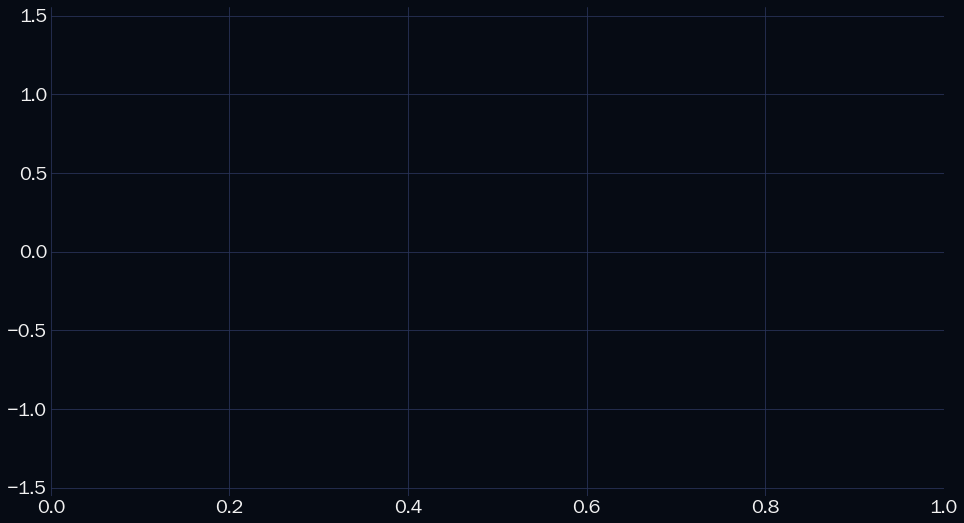

In [55]:
fig, ax = plt.subplots(figsize=(16,9))
camera = Camera(fig)

ax.set_ylim([1.1*np.min(Y2), 1.1*np.max(Y2)])

plt.style.use("seaborn-dark")
plt.rcParams["font.family"] = "Franklin Gothic Book"
plt.rcParams["font.size"] = 20
plt.rcParams["font.weight"] = "bold"
for param in ['figure.facecolor', 'axes.facecolor', 'savefig.facecolor']:
    plt.rcParams[param] = '#060b14'
for param in ['text.color', 'axes.labelcolor', 'xtick.color', 'ytick.color']:
    plt.rcParams[param] = '0.95'


ax.grid(color='#2A3459')

<h3>Training</h3>

<h5> Function to compute the gradient descent stepchange, based on ADAM </h5>

In [56]:
def get_stepchange(m_par, v_par, dF, k):
    m_par[0] = beta1*m_par[0] + (1 - beta1) * dF
    v_par[0] = beta2*v_par[0] + (1 - beta2) * dF**2
    
    mHat = m_par[0]/(1 - beta1**k)
    vHat = v_par[0]/(1 - beta2**k)
    
    return eta*mHat/(np.sqrt(vHat) + epsilon)

<h5> The training iterations </h5>

In [57]:
for iteration in tqdm(range(MAX)):
    H = sigm(W@x2  +  B) #adds vector B to every column of W*x
    O = V*H
    O = np.sum(O, axis = 0)
    O = O[np.newaxis, :]

    delV = (O - Y2)
    
    dV = H*delV
    dV = np.sum(dV,1)/(Tsize)
    dV = dV[:, np.newaxis]
    
    delW = H*(1 - H)*(delV*V) #H is the output of the sigmoid. H*(1- H) = derivative of sigmoid
    
    dW = x2*delW
    dW = np.sum(dW,1)/(Tsize)
    dW = dW[:, np.newaxis]
    
    dB = delW
    dB = np.sum(dB,1)/(Tsize)
    dB = dB[:, np.newaxis]
    
    #Gradient descent update step
    W = W - get_stepchange(m_parW, v_parW, dW, iteration + 1)
    
    V = V - get_stepchange(m_parV, v_parV, dV, iteration + 1)
    
    B = B - get_stepchange(m_parB, v_parB, dB, iteration + 1)

    loss_vals.append(np.sum((O - Y2)**2)/Tsize)
    
    if not iteration%skip_frame_capture: #We don't capture the frame in every iteration, to make the animation faster
        ax.plot(x2[0], O[0], c = '#47DBCD', linewidth=6.0)
        ax.scatter(x2[0], Y2[0], c = '#ff0066', alpha = 0.7, s = 100)
    
        camera.snap()

100%|█████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:05<00:00, 391.46it/s]


<h3>Output</h3>

<h5>Creating the animation</h5>

In [58]:
animation = camera.animate(interval = 20, blit=True) #Increase interval to increase animation duration

<h5> Viewing the animation on notebook </h5>

In [59]:
HTML(animation.to_html5_video())

<h5> Saving the animation on disk </h5>

In [60]:
animation.save('output.mov', dpi = 240, fps = 60) #resolution = width x dpi, fps = frames per second

In [61]:
animation.save('output.gif', dpi = 40, writer = 'imagemagick', fps = 50)

<h5> Plotting the loss curve </h5>

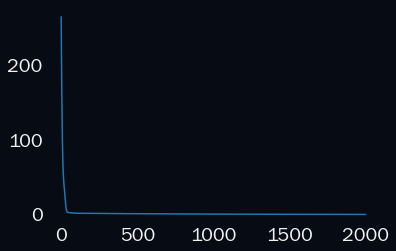

In [62]:
plt.plot(range(MAX), loss_vals)